# Spark Project Overview

`Sparkify` is a fictitious streaming service, Millions of users play their favorite songs through music streaming services on a daily basis, either through a free tier plan that plays advertisements, or by using a premium subscription model, which offers additional functionalities and is typically ad-free. Users can upgrade or downgrade their subscription plan any time, but also cancel it altogether, so it is very important to make sure they like the service. 

The goal in this project was to help the up-and-coming `Sparkify` business by building and training a binary classifier that is able to accurately identify users who cancelled the Sparkify music streaming service, based on the patterns obtained from their past activity and interaction with the service. A successfully trained model could be deployed into `Sparkify` infrastructure to identify users who are likely to churn in advance.

The model development was performed on the medium-size dataset (243MB)

The model development process consists of the following steps:
- Load and Cleanse Data
- Exploratory Data & Analysis
- Feature Engineering
- Modeling

`Understanding data information`
- userId: user identifier
- auth: authentication level (Logged In, Logged Out, Cancelled, Guest)
- firstName: user's first name
- gender: user's gender
- itemInSession: log count in a given session
- lastName: user's last name
- length: song's length in seconds
- level: subscription level
- location: user's location
- method: http request method
- page: type of interaction
- registration: user's registration timestamp
- sessionId: session to which the log belongs to
- song: song name
- status: http status code
- ts: timestamp of a given log
- userAgent: agent used by the user to access the streaming service
- artist: name of the singer

# Load and Cleanse Data
- Check whether the important value (userId, sessionId) is missing or not.

In [1]:
import pyspark.sql.functions as F

from pyspark.sql import SparkSession

from pyspark.sql.functions import udf, desc, asc, avg
from pyspark.sql.functions import sum as Fsum

from pyspark.sql.types import StringType, IntegerType

from pyspark.sql import Window

import datetime
import seaborn as sns

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set()

In [2]:
spark = SparkSession.builder\
        .appName('spark_project').getOrCreate()
user_log = spark.read.json('medium-sparkify-event-data.json')

In [3]:
# check the frame of the data
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [4]:
# check the amount of the data
total_row = user_log.count()
print(f'The total number of data is {total_row}')

The total number of data is 543705


In [5]:
# check the information
user_log.describe(['artist','auth','firstName','gender','itemInSession','lastName','length']).show()

+-------+-----------------+----------+---------+------+------------------+--------+------------------+
|summary|           artist|      auth|firstName|gender|     itemInSession|lastName|            length|
+-------+-----------------+----------+---------+------+------------------+--------+------------------+
|  count|           432877|    543705|   528005|528005|            543705|  528005|            432877|
|   mean|527.5289537712895|      null|     null|  null|107.30629109535502|    null|248.66459278007585|
| stddev|966.1072451772756|      null|     null|  null|116.72350849188119|    null| 98.41266955052022|
|    min|              !!!| Cancelled|  Aaliyah|     F|                 0|  Abbott|           0.78322|
|    max|ÃÂlafur Arnalds|Logged Out|   Zyonna|     M|              1005|  Wright|        3024.66567|
+-------+-----------------+----------+---------+------+------------------+--------+------------------+



- The `artist` can be null since it depends on whether the user is in the song-played page
- The number of null value of `firstName`, `lastName` and `gender` is the same
- `auth` and `itemInSession` no null value

In [6]:
user_log.describe(['level','location','method','page','registration']).show()

+-------+------+----------------+------+-------+--------------------+
|summary| level|        location|method|   page|        registration|
+-------+------+----------------+------+-------+--------------------+
|  count|543705|          528005|543705| 543705|              528005|
|   mean|  null|            null|  null|   null|1.535523414863871...|
| stddev|  null|            null|  null|   null|3.0787254929958086E9|
|    min|  free|       Akron, OH|   GET|  About|       1509854193000|
|    max|  paid|York-Hanover, PA|   PUT|Upgrade|       1543073874000|
+-------+------+----------------+------+-------+--------------------+



- `level`, `method` and `page` no null value
- number of null value of `location` and `registration` is the same as `firstName`, `lastName`, `gender` (these are all user info)

In [7]:
user_log.describe(['sessionID','song','status','ts','userAgent','userId']).show()

+-------+------------------+--------------------+------------------+--------------------+--------------------+------------------+
|summary|         sessionID|                song|            status|                  ts|           userAgent|            userId|
+-------+------------------+--------------------+------------------+--------------------+--------------------+------------------+
|  count|            543705|              432877|            543705|              543705|              528005|            543705|
|   mean|2040.8143533717732|            Infinity|210.01829116892432|1.540964541209763...|                null| 60268.42669103512|
| stddev|1434.3389310782725|                 NaN|  31.4719190215672|1.4820571449006093E9|                null|109898.82324176555|
|    min|                 1|ÃÂg ÃÂtti Gr...|               200|       1538352011000|"Mozilla/5.0 (Mac...|                  |
|    max|              4808|ÃÂ¾etta Gerist Ã...|               404|       1543622466000|M

- `sessionID`, `userId`, `status`, `ts` no null value
- number of `song` is the same as `artist`
- `userAgent` is part of user info

In [8]:
# No null value in userId and sessionID, explore more
user_log.select('userId').dropDuplicates().sort('userId').show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [3]:
# drop the ""
user_log_clean = user_log.filter(user_log['userId'] != "")
print(f'Now the number of data after cleansing is {user_log_clean.count()}')

Now the number of data after cleansing is 528005


In [4]:
# deal with the ts
# turn ts into year, month, day and hour
get_year = udf(lambda x: datetime.datetime.fromtimestamp(x/1000).year)
get_month = udf(lambda x: datetime.datetime.fromtimestamp(x/1000).month)
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x/1000).day)
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x/1000).hour)

# add two new columns datetime and hour
user_log_clean = user_log_clean.withColumn('year', get_year(user_log_clean.ts))
user_log_clean = user_log_clean.withColumn('month', get_month(user_log_clean.ts))
user_log_clean = user_log_clean.withColumn('day', get_day(user_log_clean.ts))
user_log_clean = user_log_clean.withColumn('hour', get_hour(user_log_clean.ts))

user_log_clean.head()

Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293', year='2018', month='10', day='1', hour='8')

# Exploratary Data Analysis

## Q&A
- `Cancellation Confirmation`事件中，有多少是付费客户，多少是免费客户，由付费转为免费，由免费转为付费
- `Cancellation Confirmation`事件中的gender, location, hour, song, artist
- 每个用户总共听了多少首歌
- downgrade后，哪些user选择了cancel
- upgrade后，哪些user选择了cancel
- user对每个页面的使用频率
- user Session次数
- user 注册了多久

## Define customer churn

In [5]:
#  add churn label: True or False
add_churn_label = udf(lambda x: 1 if x=='Cancellation Confirmation' else 0, IntegerType())
user_log_clean = user_log_clean.withColumn('churn', add_churn_label('page'))

In [6]:
# mark the user who downgrade or upgrade
# mark downgrade as 1, upgrade as 2
grade_flag = udf(lambda x: 1 if x=='Submit Downgrade' else 2 if x=='Submit Upgrade' else 0, IntegerType())
# add new columns downgraded, upgraded
user_log_clean = user_log_clean.withColumn('graded', grade_flag('page'))
#user_log_copy.select(["userId", "firstname", "ts", "page", "level", "graded"]).where(user_log_copy.userId == "162").sort("ts").collect()
windowval = Window.partitionBy('userId').orderBy('ts').rangeBetween(Window.unboundedPreceding, 0)
user_log_clean = user_log_clean.withColumn("phase", Fsum('graded').over(windowval))
user_log_clean.select(["userId", "firstname", "ts", "page", "level", "graded","phase"])\
             .where(user_log_clean.userId == "162").sort(user_log_clean.ts.desc()).take(5)

[Row(userId='162', firstname='Lakyla', ts=1542055421000, page='Cancel', level='paid', graded=0, phase=2),
 Row(userId='162', firstname='Lakyla', ts=1542055421000, page='Cancellation Confirmation', level='paid', graded=0, phase=2),
 Row(userId='162', firstname='Lakyla', ts=1542055420000, page='Roll Advert', level='paid', graded=0, phase=2),
 Row(userId='162', firstname='Lakyla', ts=1542054649000, page='NextSong', level='paid', graded=0, phase=2),
 Row(userId='162', firstname='Lakyla', ts=1542054358000, page='NextSong', level='paid', graded=0, phase=2)]

In [7]:
# use coalesce to make sure no shuffle!!!
user_log_label = user_log_clean.select('userId','gender','location','level','ts','page','phase','churn')\
                               .sort(user_log_clean.userId, user_log_clean.ts.desc(), user_log_clean.page.desc())\
                               .coalesce(1).drop_duplicates(['userId']).sort('userId')
print(f'The number of users marked as churn is {user_log_label.filter(user_log_label.churn==1).count()}')
#user_log_label.write.save(out_path, format='csv', header=True)
#user_log_label = spark.read.csv(out_path, header=True)
#user_log_label.count()

The number of users marked as churn is 99


some users went through both `downgraded` and `upgraded` (Phase>=3)

In [15]:
# see the behavior of user 100011 (phase=8)
user_log_clean.select('userId','level','graded','phase','page')\
.where((user_log_clean.userId=='100011')&((user_log_clean.page=='Submit Downgrade')|(user_log_clean.page=='Submit Upgrade')))\
.sort(user_log_clean.ts.desc()).collect()

[Row(userId='100011', level='free', graded=2, phase=8, page='Submit Upgrade'),
 Row(userId='100011', level='paid', graded=1, phase=6, page='Submit Downgrade'),
 Row(userId='100011', level='free', graded=2, phase=5, page='Submit Upgrade'),
 Row(userId='100011', level='paid', graded=1, phase=3, page='Submit Downgrade'),
 Row(userId='100011', level='free', graded=2, phase=2, page='Submit Upgrade')]

Text(0, 0.5, 'count')

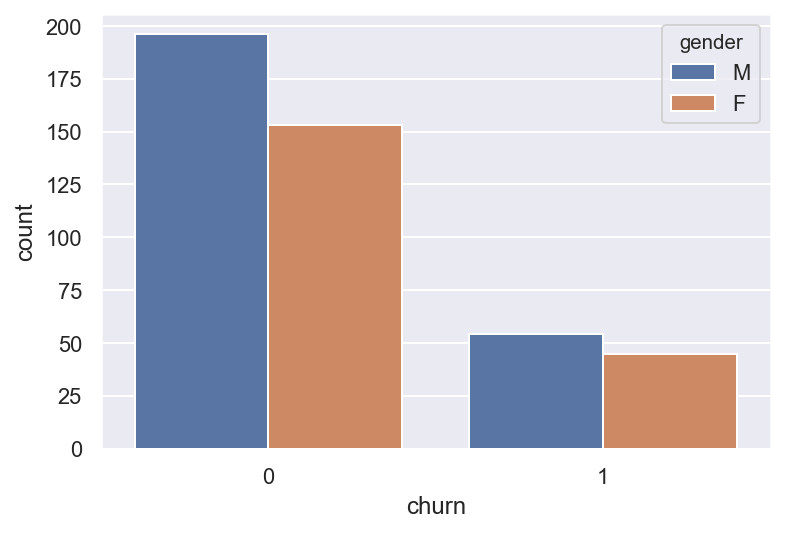

In [16]:
# check male, female
gender_df = user_log_label.select('gender','churn').groupby('gender','churn').count().toPandas()
sns.barplot(x='churn',y='count',hue='gender',data=gender_df)
plt.xlabel('churn')
plt.ylabel('count')

Text(0, 0.5, 'count')

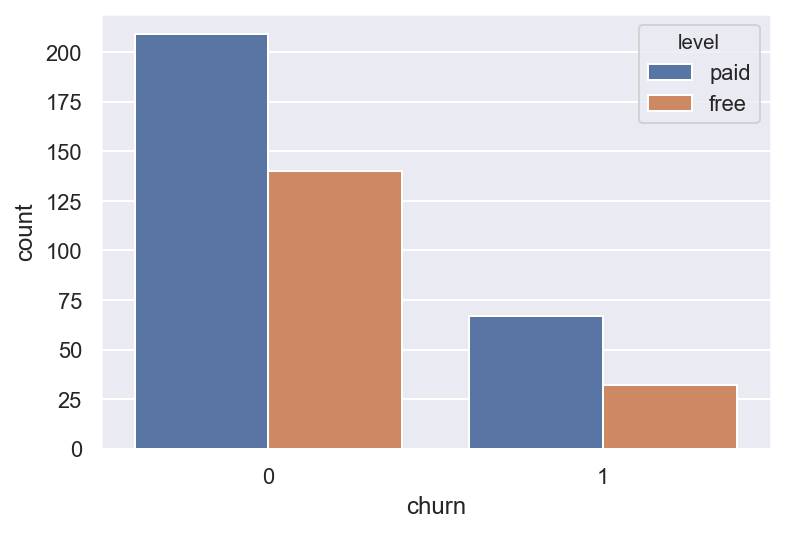

In [17]:
# check level
level_df = user_log_label.select('level','churn').groupby('level','churn').count().toPandas()
sns.barplot(x='churn',y='count',hue='level',data=level_df)
plt.xlabel('churn')
plt.ylabel('count')

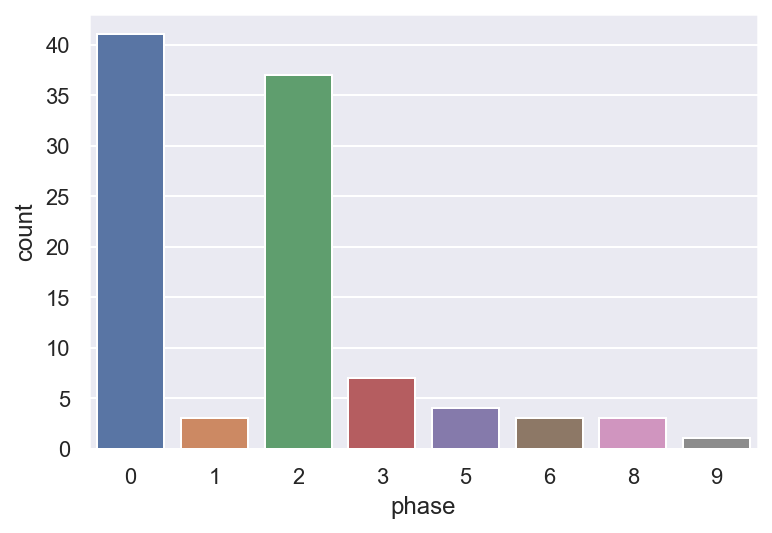

In [19]:
# phase and churn
phase_df = user_log_label.filter(user_log_label.churn==1).select('phase').groupby('phase').count().toPandas()
sns.barplot(x='phase',y='count',data=phase_df)

In [ ]:
# number of songs each user listen
num_songs_df = user_log_clean.select('userId').where(user_log_clean.page=='NextSong').groupby('userId').count().toPandas()
sns.distplot(num_songs_df['count'], kde=False)
plt.xlim(-1, 0.8*max(num_songs_df['count']))

In [9]:
# join number of songs with user_log_label
user_num_songs = user_log_clean.select('userId').where(user_log_clean.page=='NextSong')\
                               .groupby('userId').count().withColumnRenamed('count','songs_listened').withColumnRenamed('userId','userIdTemp')
user_log_label = user_log_label.join(user_num_songs, user_log_label.userId==user_num_songs.userIdTemp, 'left_outer').drop('userIdTemp')
user_log_label = user_log_label.drop('song_userId')
user_log_label.show()

+------+------+--------------------+-----+-------------+--------------------+-----+-----+--------------+
|userId|gender|            location|level|           ts|                page|phase|churn|songs_listened|
+------+------+--------------------+-----+-------------+--------------------+-----+-----+--------------+
|100010|     F|Bridgeport-Stamfo...| free|1539254318000|Cancellation Conf...|    0|    1|            96|
|200002|     M|Chicago-Napervill...| paid|1540877026000|Cancellation Conf...|    2|    1|           310|
|   296|     F|Allentown-Bethleh...| paid|1539187234000|Cancellation Conf...|    2|    1|           112|
|   125|     M|  Corpus Christi, TX| free|1542265610000|     Add to Playlist|    0|    0|            62|
|   124|     F|Vineland-Bridgeto...| paid|1541948983000|Cancellation Conf...|    0|    1|          1826|
|    51|     M|Lexington-Fayette...| paid|1539709266000|Cancellation Conf...|    0|    1|           266|
|     7|     M|Seattle-Tacoma-Be...| free|1543409350000

(-1, 2000)

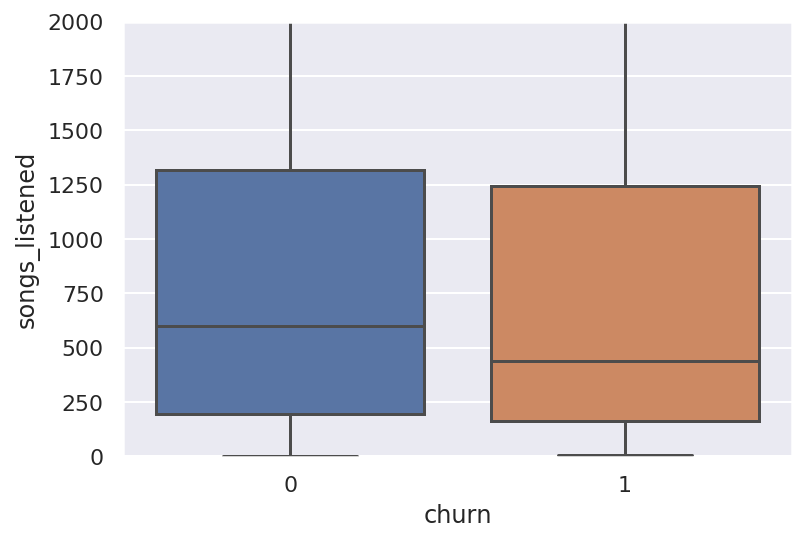

In [62]:
# number of songs users who marked as churn listen
songs_df = user_log_label.select('songs_listened','churn').toPandas()
sns.boxplot(x='churn',y='songs_listened',data=songs_df)
plt.ylim(-1,2000);

In [11]:
### thumbs up or down
user_thumbs_down = user_log_clean.select('userId').where(user_log_clean.page=='Thumbs Down')\
                                 .groupby('userId').count().withColumnRenamed('count', 'num_thumbs_down')
user_thumbs_up = user_log_clean.select('userId').where(user_log_clean.page=='Thumbs Up')\
                                 .groupby('userId').count().withColumnRenamed('count', 'num_thumbs_up')
#assert user_thumbs_down.count()==user_thumbs_up.count()==user_log_label.count()
user_log_label = user_log_label.join(user_thumbs_down, user_log_label.userId==user_thumbs_down.userId, 'outer').drop(user_thumbs_down.userId)
user_log_label = user_log_label.join(user_thumbs_up, user_log_label.userId==user_thumbs_up.userId, 'outer').drop(user_thumbs_up.userId)
user_log_label = user_log_label.fillna(0, subset=['num_thumbs_down','num_thumbs_up'])
user_log_label.show()

+------+--------------------+-----+-------------+--------------------+-----+-----+--------------+------+---------------+-------------+
|gender|            location|level|           ts|                page|phase|churn|songs_listened|userId|num_thumbs_down|num_thumbs_up|
+------+--------------------+-----+-------------+--------------------+-----+-----+--------------+------+---------------+-------------+
|     F|Bridgeport-Stamfo...| free|1539254318000|Cancellation Conf...|    0|    1|            96|100010|              3|            4|
|     M|Chicago-Napervill...| paid|1540877026000|Cancellation Conf...|    2|    1|           310|200002|              5|           15|
|  null|                null| null|         null|                null| null| null|          null|  null|              0|            8|
|     M|  Corpus Christi, TX| free|1542265610000|     Add to Playlist|    0|    0|            62|   125|              1|            3|
|     F|Vineland-Bridgeto...| paid|1541948983000|Cancel

In [34]:
# count thumbs
thumbs_df = user_log_label.select('churn','num_thumbs_down','num_thumbs_up').groupby('num_thumbs_down','churn').sum().toPandas()
thumbs_df

,churn,sum(churn),sum(num_thumbs_down),sum(num_thumbs_up)
0,1,99,1156,4300
1,0,0,3755,19526


In [37]:
# session次数
user_log_clean.select('userId','sessionID').groupby('userId').count().show()

+------+-----+
|userId|count|
+------+-----+
|100010|  137|
|200002|  395|
|   296|  152|
|   125|   84|
|    51|  328|
|   124| 2156|
|     7|  600|
|200037|  155|
|   205| 1244|
|   169|  149|
|   272|  131|
|    54|  624|
|   282| 3191|
|   232| 2325|
|   234| 2021|
|    15| 2173|
|   155|  172|
|200043|  808|
|   154|  126|
|   132|  144|
+------+-----+
only showing top 20 rows



In [12]:
# 平均会话时长
user_sessionTime = user_log_clean.groupby('userId','sessionID').agg(((F.max(user_log_clean.ts)-F.min(user_log_clean.ts))/(1000*60))
                                                 .alias('sessionTime')).sort('userId')
user_sessionTime_stat = user_sessionTime.groupby('userId').agg(avg(user_sessionTime.sessionTime).alias('AvgSessionTime'),
                                                               F.max(user_sessionTime.sessionTime).alias('MaxSessionTime'),
                                                               F.min(user_sessionTime.sessionTime).alias('MinSessionTime')).sort('userId')
user_sessionTime_stat.show()

+------+------------------+------------------+--------------------+
|userId|    AvgSessionTime|    MaxSessionTime|      MinSessionTime|
+------+------------------+------------------+--------------------+
|    10|            1502.4|            1502.4|              1502.4|
|   100|350.47777777777776|1645.2333333333333|0.016666666666666666|
|100001|137.66111111111113|202.13333333333333|   42.13333333333333|
|100002|          150.2625|333.43333333333334|   52.63333333333333|
|100003| 296.9277777777778|1277.2333333333333|                 0.0|
|100004|222.09666666666664|            444.75|  48.516666666666666|
|100005|139.03333333333333|223.68333333333334|   54.38333333333333|
|100006| 235.9766666666667|            415.05|                 0.0|
|100007| 288.9013888888889|            749.25|   37.11666666666667|
|100008| 262.2944444444444|             386.0|  141.41666666666666|
|100009|402.93000000000006|           1386.45|                 0.0|
|100010|           210.375|222.56666666666666|  

In [13]:
# 每个session平均听歌数量
user_session_songs = user_log_clean.filter(user_log_clean.page=='NextSong').groupby('userId','sessionID').count()
user_per_session_songs = user_session_songs.groupby('userId').agg(avg(user_session_songs['count']).alias('songs_per_session')).sort('userId')
user_per_session_songs.show()

+------+------------------+
|userId| songs_per_session|
+------+------------------+
|    10|             360.0|
|   100| 86.71794871794872|
|100001|              32.0|
|100002|             34.25|
|100003|            82.625|
|100004|              52.4|
|100005|              36.0|
|100006|             73.75|
|100007| 71.08333333333333|
|100008| 64.33333333333333|
|100009|             100.5|
|100010|              48.0|
|100011|             51.05|
|100012|              22.4|
|100013|              20.0|
|100014|              83.0|
|100015|             31.75|
|100016|27.166666666666668|
|100017|              63.5|
|100018|              62.0|
+------+------------------+
only showing top 20 rows



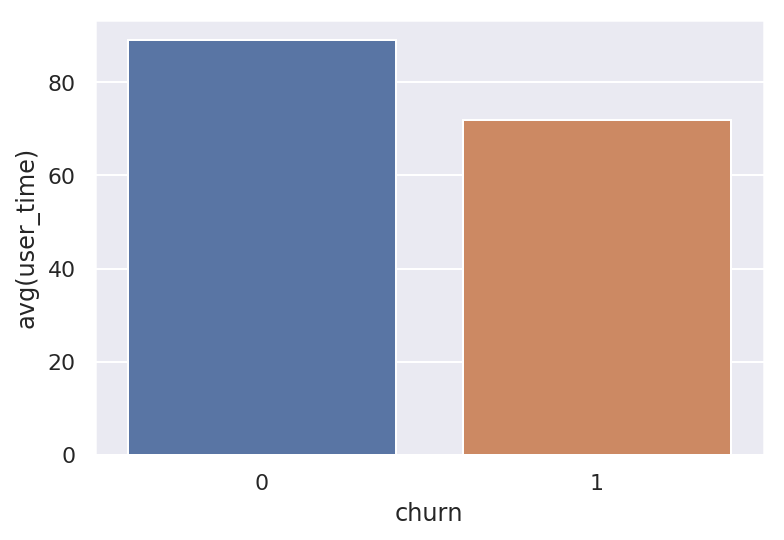

In [14]:
### registration time
user_use_time = user_log_clean.groupby('userId').agg(((F.max(user_log_clean.ts)-F.max(user_log_clean.registration))/(1000*60*60*24))\
                                                     .alias('user_time')).sort('userId')
user_log_label = user_log_label.join(user_use_time, user_log_label.userId==user_use_time.userId).drop(user_use_time.userId)
registration_df = user_log_label.groupby('churn').agg(avg(user_log_label.user_time)).toPandas()
sns.barplot(x='churn',y='avg(user_time)',data=registration_df);

In [56]:
#location
user_log_clean.select('location').drop_duplicates().take(10)

[Row(location='Atlantic City-Hammonton, NJ'),
 Row(location='Gainesville, FL'),
 Row(location='Richmond, VA'),
 Row(location='Tucson, AZ'),
 Row(location='Oskaloosa, IA'),
 Row(location='San Diego-Carlsbad, CA'),
 Row(location='Deltona-Daytona Beach-Ormond Beach, FL'),
 Row(location='Cleveland-Elyria, OH'),
 Row(location='Medford, OR'),
 Row(location='Kingsport-Bristol-Bristol, TN-VA')]

In [15]:
# check all the page types
user_log_clean.select('page').drop_duplicates().sort('page').collect()

[Row(page='About'),
 Row(page='Add Friend'),
 Row(page='Add to Playlist'),
 Row(page='Cancel'),
 Row(page='Cancellation Confirmation'),
 Row(page='Downgrade'),
 Row(page='Error'),
 Row(page='Help'),
 Row(page='Home'),
 Row(page='Logout'),
 Row(page='NextSong'),
 Row(page='Roll Advert'),
 Row(page='Save Settings'),
 Row(page='Settings'),
 Row(page='Submit Downgrade'),
 Row(page='Submit Upgrade'),
 Row(page='Thumbs Down'),
 Row(page='Thumbs Up'),
 Row(page='Upgrade')]

Text(0.5, 0, 'Hour')

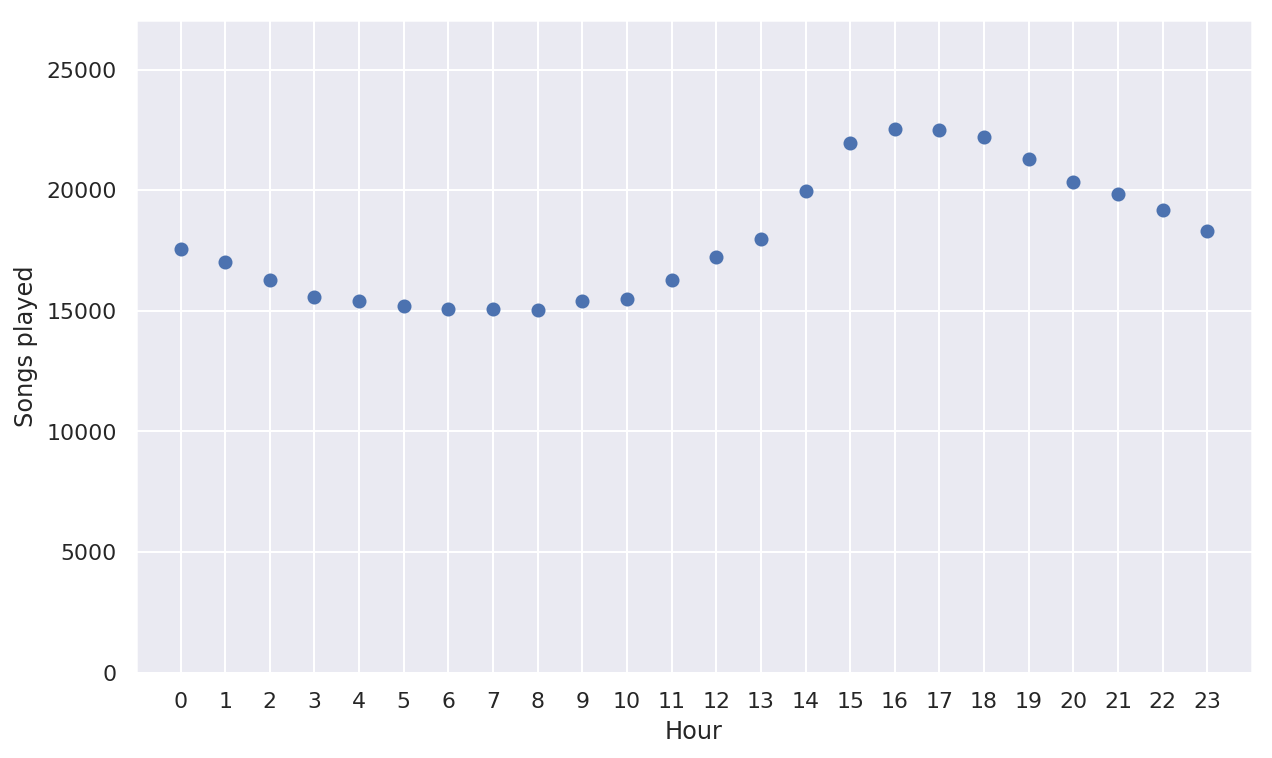

In [24]:
# number of songs are played for each hour using page=='NextSong'
song_in_hour = user_log_clean.select('hour').where(user_log_clean['page']=='NextSong').groupby('hour').count()\
              .orderBy(user_log_clean['hour'].cast('float')).toPandas()
plt.figure(figsize=(10,6))
plt.scatter(song_in_hour['hour'], song_in_hour['count'])
plt.xlim(-1,24)
plt.ylim(0, 1.2*max(song_in_hour['count']))
plt.ylabel('Songs played')
plt.xlabel('Hour')

Text(0.5, 0, 'Hour')

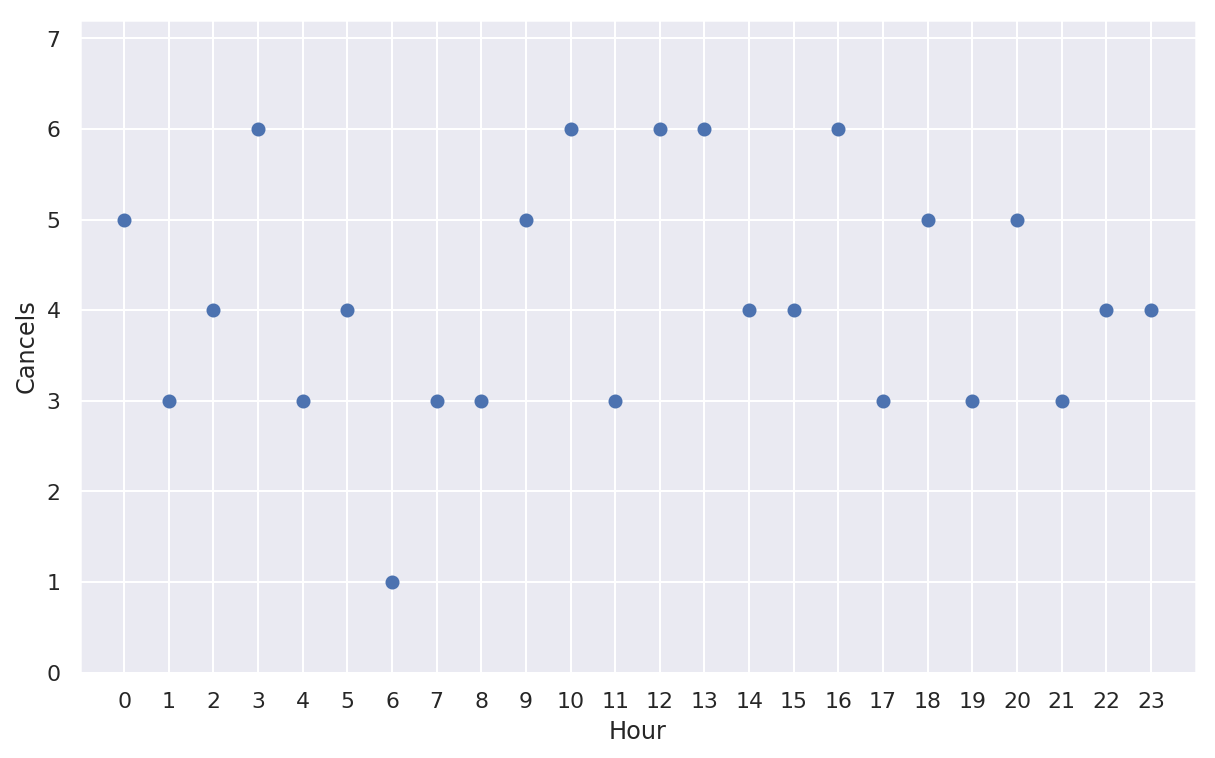

In [25]:
cancel_in_hour = user_log_clean.select('hour').where(user_log_clean['page']=='Cancellation Confirmation').groupby('hour').count()\
              .orderBy(user_log_clean['hour'].cast('float')).toPandas()
plt.figure(figsize=(10,6))
plt.scatter(cancel_in_hour['hour'], cancel_in_hour['count'])
plt.xlim(-1,24)
plt.ylim(0, 1.2*max(cancel_in_hour['count']))
plt.ylabel('Cancels')
plt.xlabel('Hour')

# Feature Engineering

In [23]:
user_log_label.head(1)

[Row(userId='10', gender='M', location='Laurel, MS', level='paid', ts=1539055364000, page='Cancellation Confirmation', phase=0, churn=1)]

## Numerical Features

### use days

In [8]:
# total use days since registration
use_days = user_log_clean.groupby('userId')\
                    .agg(((F.max(user_log_clean.ts)-F.max(user_log_clean.registration))/(1000*60*60*24))
                         .alias('total_use_days'))
use_days = use_days.select('userId',F.floor(use_days.total_use_days))\
                       .sort('userId').withColumnRenamed('FLOOR(total_use_days)', 'total_use_days')
assert use_days.count()==448
use_days.show(1)

+------+--------------+
|userId|total_use_days|
+------+--------------+
|    10|            10|
+------+--------------+
only showing top 1 row



### page type features
- number of interactions
- number of songs
- number of thumbs-up, thumbs-down
- number of friends
- number of songs added to playlists
- number of times return to home
- number of advertisement played
- number of help page visit
- number of settings page visit
- number of error page visit

In [9]:
# number of interactions
num_inter = user_log_clean.select('userId','page').groupby('userId').count().sort('userId')
assert num_inter.count() == 448
# calculate the number of interactions per day to eliminate the effect of different use days of each user
num_inter = num_inter.join(use_days, num_inter.userId==use_days.userId).drop(use_days.userId)
num_inter_perday = num_inter.withColumn('num_inter_perday', num_inter['count']/num_inter['total_use_days'])\
                            .drop('count', 'total_use_days').sort('userId')      
num_inter_perday.show(2)

+------+-----------------+
|userId| num_inter_perday|
+------+-----------------+
|    10|             42.3|
|   100|61.52307692307692|
+------+-----------------+
only showing top 2 rows



In [13]:
def perday_feature(page):
    
    num = user_log_clean.select('userId').where(user_log_clean.page==page)\
                            .groupby('userId').count().sort('userId').withColumnRenamed('userId','userId1')
    # number per day
    temp_view = user_log_clean.select('userId').drop_duplicates().sort('userId')
    num = temp_view.join(num, temp_view.userId==num.userId1,'left_outer').drop('userId1')\
                           .fillna(0).sort('userId')
    assert num.count() == 448
    num = num.join(use_days, num.userId==use_days.userId).drop(use_days.userId)
    num_perday = num.withColumn('num_'+page.split()[-1]+'_perday', num['count']/num['total_use_days'])\
                                    .drop('count','total_use_days').sort('userId')
    return num_perday

In [15]:
page_lst = ['Add Friend','Add to Playlist','Error','Help','Home','NextSong','Roll Advert',
            'Save Settings','Thumbs Down','Thumbs Up']
interaction_feature = user_log_clean.select('userId').drop_duplicates().sort('userId')

for page in page_lst:
    num_perday = perday_feature(page)
    interaction_feature = interaction_feature.join(num_perday, interaction_feature.userId==num_perday.userId)\
                                     .drop(num_perday.userId).sort('userId')
# join interaction_perday
interaction_feature = interaction_feature.join(num_inter_perday, 
                                               interaction_feature.userId==num_inter_perday.userId)\
                                 .drop(num_inter_perday.userId).sort('userId')
assert interaction_feature.count() == 448
interaction_feature.show(5)

+------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+------------------+
|userId|   num_Friend_perday| num_Playlist_perday|    num_Error_perday|     num_Help_perday|    num_Home_perday|num_NextSong_perday|  num_Advert_perday|num_Settings_perday|     num_Down_perday|      num_Up_perday|  num_inter_perday|
+------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+------------------+
|    10|                 0.3|                 1.4|                 0.1|                 0.3|                1.5|               36.0|                0.0|                0.0|                 0.1|                1.7|              42.3|
|   100|  1.0923076923076922|  1.4461538461538461|0.0461538461538461

In [17]:
interaction_feature.printSchema()

root
 |-- userId: string (nullable = true)
 |-- num_Friend_perday: double (nullable = true)
 |-- num_Playlist_perday: double (nullable = true)
 |-- num_Error_perday: double (nullable = true)
 |-- num_Help_perday: double (nullable = true)
 |-- num_Home_perday: double (nullable = true)
 |-- num_NextSong_perday: double (nullable = true)
 |-- num_Advert_perday: double (nullable = true)
 |-- num_Settings_perday: double (nullable = true)
 |-- num_Down_perday: double (nullable = true)
 |-- num_Up_perday: double (nullable = true)
 |-- num_inter_perday: double (nullable = true)



###  Ratio
- songs ratio
- positive ratio
- negative ratio

In [38]:
def ratio_feature(page, num_inter):
    num = user_log_clean.select('userId').where(user_log_clean.page==page).groupby('userId').count().sort('userId')\
                          .withColumnRenamed('userId','userId1').withColumnRenamed('count','num')
    num = num_inter.join(num, num_inter.userId==num.userId1,'left_outer').drop('userId1')\
                           .fillna(0).sort('userId')
    num_ratio = num.withColumn('num_'+page.split()[-1]+'_ratio', num['num']/num['count'])\
                               .drop('num','count').sort('userId')
    assert num_ratio.count()==448
    
    return num_ratio

In [39]:
# total number of interactions of each user
interactions = user_log_clean.select('userId','page').groupby('userId').count().sort('userId')

In [20]:
# songs ratio
num_songs_ratio = ratio_feature('NextSong', interactions)
num_songs_ratio.show(5)

+------+------------------+
|userId|num_NextSong_ratio|
+------+------------------+
|    10| 0.851063829787234|
|   100|0.8457114278569643|
|100001|0.7164179104477612|
|100002|0.7740112994350282|
|100003|0.7992744860943168|
+------+------------------+
only showing top 5 rows



In [21]:
page_lst = ['Add Friend','Add to Playlist','Error','Help','Home','NextSong','Roll Advert',
            'Save Settings','Thumbs Down','Thumbs Up']
# positive ratio: Add Friend, Add to Playlist, Thumbs Down
pos_page_lst = ['Add Friend', 'Add to Playlist', 'Thumbs Up']
pos_ratio = user_log_clean.select('userId').drop_duplicates().sort('userId')
for page in pos_page_lst:
    num_ratio = ratio_feature(page, interactions)
    pos_ratio = pos_ratio.join(num_ratio, pos_ratio.userId==num_ratio.userId).drop(num_ratio.userId)
assert pos_ratio.count() == 448
pos_ratio = pos_ratio.withColumn('positive_ratio', 
                (pos_ratio['num_Friend_ratio']+pos_ratio['num_Playlist_ratio']+pos_ratio['num_Up_ratio']))
positive_ratio = pos_ratio.select('userId', 'positive_ratio').sort('userId')
assert pos_ratio.count() == 448
positive_ratio.show(5)

+------+-------------------+
|userId|     positive_ratio|
+------+-------------------+
|    10|0.08037825059101655|
|   100|0.07701925481370342|
|100001|0.06716417910447761|
|100002|0.06214689265536723|
|100003|0.05199516324062878|
+------+-------------------+
only showing top 5 rows



In [41]:
# negative ratio: Error, Help, Save Settings, Down
neg_page_lst = ['Error', 'Help', 'Save Settings', 'Thumbs Down']
neg_ratio = user_log_clean.select('userId').drop_duplicates().sort('userId')
for page in neg_page_lst:
    num_ratio = ratio_feature(page, interactions)
    neg_ratio = neg_ratio.join(num_ratio, neg_ratio.userId==num_ratio.userId).drop(num_ratio.userId)
assert neg_ratio.count() == 448
neg_ratio = neg_ratio.withColumn('negative_ratio', 
                (neg_ratio['num_Error_ratio']+neg_ratio['num_Help_ratio']+neg_ratio['num_Settings_ratio']+neg_ratio['num_Down_ratio']))
negative_ratio = neg_ratio.select('userId', 'negative_ratio').sort('userId')
assert negative_ratio.count() == 448
negative_ratio.show(5)

+------+--------------------+
|userId|      negative_ratio|
+------+--------------------+
|    10| 0.01182033096926714|
|   100|0.014753688422105527|
|100001|0.014925373134328358|
|100002|0.022598870056497175|
|100003|0.018137847642079805|
+------+--------------------+
only showing top 5 rows



In [42]:
ratio_feature = num_songs_ratio.join(positive_ratio, num_songs_ratio.userId==positive_ratio.userId)\
                               .drop(positive_ratio.userId).sort('userId')
ratio_feature = ratio_feature.join(negative_ratio, ratio_feature.userId==negative_ratio.userId)\
                             .drop(negative_ratio.userId).sort('userId')

In [161]:
data_for_model.printSchema()

root
 |-- userId: string (nullable = true)
 |-- num_Friend_perday: string (nullable = true)
 |-- num_Error_perday: string (nullable = true)
 |-- num_Help_perday: string (nullable = true)
 |-- num_NextSong_perday: string (nullable = true)
 |-- num_Advert_perday: string (nullable = true)
 |-- num_settings_perday: string (nullable = true)
 |-- num_Down_perday: string (nullable = true)
 |-- num_Up_perday: string (nullable = true)
 |-- num_NextSong_ratio: string (nullable = true)
 |-- positive_ratio: string (nullable = true)
 |-- negative_ratio: string (nullable = true)
 |-- AvgSessionTime: string (nullable = true)
 |-- MaxSessionTime: string (nullable = true)
 |-- MinSessionTime: string (nullable = true)
 |-- num_songs_listened_per_session: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- level: string (nullable = true)
 |-- downgraded: string (nullable = true)
 |-- upgraded: string (nullable = true)
 |-- churn: string (nullable = true)



### session feature
- average session time (day)
- maximum session time (day)
- minimum session time (day)
- songs per session

In [24]:
sessionTime = user_log_clean.groupby('userId','sessionID')\
                            .agg(((F.max(user_log_clean.ts)-F.min(user_log_clean.ts))/(1000*60*60*24))\
                                 .alias('sessionTime')).sort('userId')
session_time_feature = sessionTime.groupby('userId').agg((F.avg(sessionTime['sessionTime'])).alias('AvgSessionTIme'),
                                                          F.max(sessionTime['sessionTime']).alias('MaxSessionTime'),
                                                          F.min(sessionTime['sessionTime']).alias('MinSessionTime'))\
                                   .sort('userId')
assert session_time_feature.count()==448
session_time_feature.show(5)

+------+-------------------+-------------------+--------------------+
|userId|     AvgSessionTIme|     MaxSessionTime|      MinSessionTime|
+------+-------------------+-------------------+--------------------+
|    10| 1.0433333333333332| 1.0433333333333332|  1.0433333333333332|
|   100|0.24338734567901227| 1.1425231481481481|1.157407407407407...|
|100001| 0.0955979938271605|0.14037037037037037| 0.02925925925925926|
|100002|0.10434895833333332|0.23155092592592594|0.036550925925925924|
|100003|0.20619984567901234| 0.8869675925925926|                 0.0|
+------+-------------------+-------------------+--------------------+
only showing top 5 rows



In [25]:
num_songs_session = user_log_clean.filter(user_log_clean.page=='NextSong').groupby('userId','sessionID').count()
num_songs_per_session_feature = num_songs_session.groupby('userId')\
          .agg(avg(num_songs_session['count']).alias('num_songs_listened_per_session')).sort('userId')
num_songs_per_session_feature = num_songs_per_session_feature\
           .select('userId',num_songs_per_session_feature.num_songs_listened_per_session)
assert num_songs_per_session_feature.count()==448
num_songs_per_session_feature.show(5)

+------+------------------------------+
|userId|num_songs_listened_per_session|
+------+------------------------------+
|    10|                         360.0|
|   100|             86.71794871794872|
|100001|                          32.0|
|100002|                         34.25|
|100003|                        82.625|
+------+------------------------------+
only showing top 5 rows



In [26]:
session_feature = session_time_feature.join(num_songs_per_session_feature, 
                                           session_time_feature.userId==num_songs_per_session_feature.userId)\
                                      .drop(num_songs_per_session_feature.userId).sort('userId')
assert session_feature.count()==448
session_feature.show(5)

+-------------------+-------------------+--------------------+------+------------------------------+
|     AvgSessionTIme|     MaxSessionTime|      MinSessionTime|userId|num_songs_listened_per_session|
+-------------------+-------------------+--------------------+------+------------------------------+
| 1.0433333333333332| 1.0433333333333332|  1.0433333333333332|    10|                         360.0|
|0.24338734567901227| 1.1425231481481481|1.157407407407407...|   100|             86.71794871794872|
| 0.0955979938271605|0.14037037037037037| 0.02925925925925926|100001|                          32.0|
|0.10434895833333332|0.23155092592592594|0.036550925925925924|100002|                         34.25|
|0.20619984567901234| 0.8869675925925926|                 0.0|100003|                        82.625|
+-------------------+-------------------+--------------------+------+------------------------------+
only showing top 5 rows



### Join Numeric Features

In [43]:
numeric_feature = interaction_feature.join(ratio_feature, interaction_feature.userId==ratio_feature.userId)\
                                     .drop(ratio_feature.userId).sort('userId')
numeric_feature = numeric_feature.join(session_feature, numeric_feature.userId==session_feature.userId)\
                                 .drop(session_feature.userId).sort('userId')
assert numeric_feature.count()==448
out_path = 'numeric_feature.csv'
numeric_feature.write.save(out_path, format='csv', header=True)

## Categorical Features
- gender
- level
- upgrade
- downgrade

In [28]:
gender_feature = user_log_label.select('userId','gender').sort('userId')
assert gender_feature.count()==448
gender_feature = gender_feature.replace(['M','F'], ['0','1'], 'gender')
gender_feature = gender_feature.select('userId',gender_feature.gender.cast('int')).sort('userId')
gender_feature.show(5)

+------+------+
|userId|gender|
+------+------+
|    10|     0|
|   100|     0|
|100001|     1|
|100002|     1|
|100003|     1|
+------+------+
only showing top 5 rows



In [29]:
level_feature = user_log_label.select('userId','level').sort('userId')
assert level_feature.count()==448
level_feature = level_feature.replace(['paid','free'], ['0','1'], 'level')
level_feature = level_feature.select('userId', level_feature.level.cast('int')).sort('userId')
level_feature.show(5)

+------+-----+
|userId|level|
+------+-----+
|    10|    0|
|   100|    0|
|100001|    1|
|100002|    1|
|100003|    0|
+------+-----+
only showing top 5 rows



In [30]:
grade_feature = user_log_label.select('userId','phase').sort('userId')
assert grade_feature.count()==448
# define functions
downgraded_mark = udf(lambda x: 1 if (x==1 or x>=3) else 0, IntegerType()) # 1是只downgrade，大于等于3是既downgrade又upgrade
upgraded_mark = udf(lambda x: 1 if (x==2 or x>=3) else 0, IntegerType())
grade_feature = grade_feature.withColumn('downgraded', downgraded_mark('phase'))
grade_feature = grade_feature.withColumn('upgraded', upgraded_mark('phase'))
grade_feature = grade_feature.drop('phase')
grade_feature.show(5)

+------+----------+--------+
|userId|downgraded|upgraded|
+------+----------+--------+
|    10|         0|       0|
|   100|         0|       1|
|100001|         0|       0|
|100002|         1|       1|
|100003|         0|       1|
+------+----------+--------+
only showing top 5 rows



In [31]:
categorical_feature = gender_feature.join(level_feature, gender_feature.userId==level_feature.userId)\
                                    .drop(level_feature.userId).sort('userId')
categorical_feature = categorical_feature.join(grade_feature, categorical_feature.userId==grade_feature.userId)\
                                    .drop(grade_feature.userId).sort('userId')
assert categorical_feature.count()==448
out_path = 'categorical_feature.csv'
categorical_feature.write.save(out_path, format='csv', header=True)

## Final Feature Selection

In [45]:
numeric_feature = spark.read.csv('numeric_feature.csv', header=True)
numeric_feature.head(1)

[Row(num_Friend_perday='0.1744186046511628', num_Playlist_perday='0.6627906976744186', num_Error_perday='0.0', num_Help_perday='0.023255813953488372', num_Home_perday='0.7093023255813954', num_NextSong_perday='18.61627906976744', num_Advert_perday='0.046511627906976744', num_Settings_perday='0.011627906976744186', num_Down_perday='0.22093023255813954', num_Up_perday='1.0116279069767442', num_inter_perday='22.069767441860463', userId='281', num_NextSong_ratio='0.8435194942044257', positive_ratio='0.08377239199157008', negative_ratio='0.011591148577449946', AvgSessionTIme='0.33545221560846566', MaxSessionTime='0.8880439814814814', MinSessionTime='0.07372685185185185', num_songs_listened_per_session='114.35714285714286')]

### correlation of numeric feature

In [47]:
numeric_feature_df = numeric_feature.toPandas()
numeric_feature_df = numeric_feature_df.drop(['userId'],axis=1).astype('float')
numeric_feature_df.head(5)

,num_Friend_perday,num_Playlist_perday,num_Error_perday,num_Help_perday,num_Home_perday,num_NextSong_perday,num_Advert_perday,num_Settings_perday,num_Down_perday,num_Up_perday,num_inter_perday,num_NextSong_ratio,positive_ratio,negative_ratio,AvgSessionTIme,MaxSessionTime,MinSessionTime,num_songs_listened_per_session
0,0.174419,0.662791,0.000000,0.023256,0.709302,18.616279,0.046512,0.011628,0.220930,1.011628,22.069767,0.843519,0.083772,0.011591,0.335452,0.888044,0.073727,114.357143
1,1.025974,0.857143,0.051948,0.246753,1.428571,34.142857,0.480519,0.038961,0.376623,1.727273,41.441558,0.823880,0.087120,0.017236,0.265346,1.275810,0.001493,93.892857
2,0.868852,1.770492,0.081967,0.393443,2.278689,57.163934,0.131148,0.114754,0.573770,3.163934,68.540984,0.834011,0.084669,0.016982,0.350573,1.017535,0.034664,124.535714
3,0.142857,0.038961,0.000000,0.012987,0.220779,4.272727,0.285714,0.000000,0.038961,0.142857,5.337662,0.800487,0.060827,0.009732,0.103302,0.360833,0.009641,36.555556
4,0.066116,0.264463,0.016529,0.049587,0.446281,8.066116,0.198347,0.033058,0.148760,0.363636,9.975207,0.808616,0.069594,0.024855,0.154886,1.195104,0.018877,54.222222


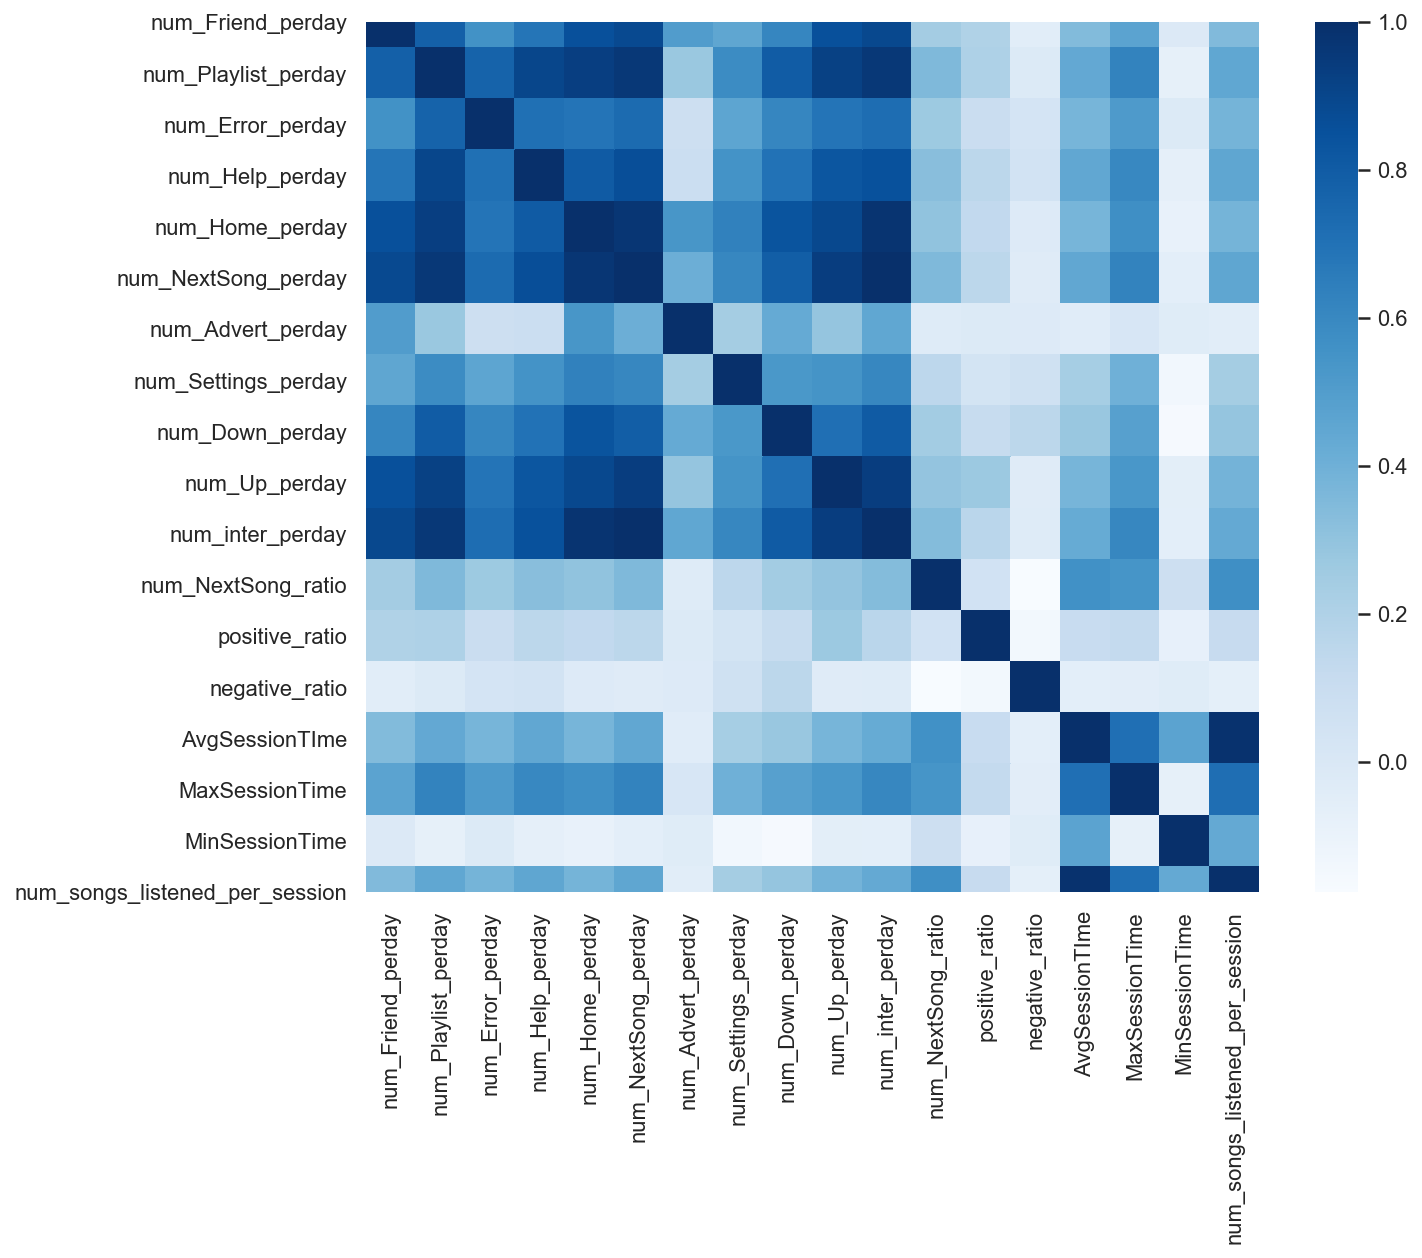

In [59]:
# heatmap
corr = numeric_feature_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap='Blues')

From the above heatmap, we can conclude that `num_NextSong_perday`, `num_Home_perday`, `num_inter_perday`, `num_Playlist_perday`are highly correlated. Since `Sparkify` is a music app, played songs matter most. As a result, num_NextSong_perday will be chosen and `num_Home_perday`, `num_inter_perday` will be removed

In [80]:
# final numeric features
numeric_feature_column = ['num_Friend_perday','num_Error_perday','num_Help_perday','num_NextSong_perday',
                          'num_Advert_perday','num_settings_perday','num_Down_perday','num_Up_perday',
                          'num_NextSong_ratio','positive_ratio','negative_ratio','AvgSessionTime',
                          'MaxSessionTime','MinSessionTime','num_songs_listened_per_session']
numeric_feature_final = numeric_feature.select(['userId']+numeric_feature_column).sort('userId')

In [70]:
numeric_feature_final.printSchema()

root
 |-- userId: string (nullable = true)
 |-- num_Friend_perday_float: float (nullable = true)
 |-- num_Error_perday_float: float (nullable = true)
 |-- num_Help_perday_float: float (nullable = true)
 |-- num_NextSong_perday_float: float (nullable = true)
 |-- num_Advert_perday_float: float (nullable = true)
 |-- num_settings_perday_float: float (nullable = true)
 |-- num_Down_perday_float: float (nullable = true)
 |-- num_Up_perday_float: float (nullable = true)
 |-- num_NextSong_ratio_float: float (nullable = true)
 |-- positive_ratio_float: float (nullable = true)
 |-- negative_ratio_float: float (nullable = true)
 |-- AvgSessionTime_float: float (nullable = true)
 |-- MaxSessionTime_float: float (nullable = true)
 |-- MinSessionTime_float: float (nullable = true)
 |-- num_songs_listened_per_session_float: float (nullable = true)



In [81]:
categorical_feature = spark.read.csv('categorical_feature.csv',header=True)
label = user_log_label.select('userId',user_log_label.churn)
assert label.count()==448
data_for_model = numeric_feature_final.join(categorical_feature, 
                                            numeric_feature_final.userId==categorical_feature.userId)\
                                      .drop(categorical_feature.userId).sort('userId')
data_for_model = data_for_model.join(label, data_for_model.userId==label.userId).drop(label.userId).sort('userId')
assert data_for_model.count() ==448
data_for_model.write.save('data_for_model.csv', format='csv', header=True)

# Modeling & Evaluation
The following three models will be chosen to train the data
- Logistic Classifier
- Random Forest Classifier
- Gradient-Boosted Tree Classifier

F1 score will be chosen as the evaluation score because of the relative small size of the dataset

In [121]:
import time

from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, GBTClassifier, RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.feature import ChiSqSelector

## Build Pipelines
- Vectorize numeric features
- StandardScale numeric features
- Vectorize categorical features
- Total Assembler numeric and categorical features

`Logistic Classifier`
- maxIter (maximum number of iterations, default=100) : 10, 30
- regParam (regularization parameter, default=0.0) : 0.0, 0.05, 0.1
- elasticNetParam (mixing parameter — 0 for L2 penalty, 1 for L1 penalty, default=0.0): 0.0, 0.5

`Random Forest Classifier`
- maxDepth (maximum tree depth, default=5): 4,5,6,7
- numTrees (number of trees, default=20): 20,40

`Gradient-Boosted Tree Classifier`
- maxDepth (maximum tree depth, default=5) : 4, 5
- maxIter (maximum number of iterations, default=20) : 20, 100

In [82]:
data_for_model = spark.read.csv('data_for_model.csv', header=True)
data_for_model.printSchema()

root
 |-- userId: string (nullable = true)
 |-- num_Friend_perday: string (nullable = true)
 |-- num_Error_perday: string (nullable = true)
 |-- num_Help_perday: string (nullable = true)
 |-- num_NextSong_perday: string (nullable = true)
 |-- num_Advert_perday: string (nullable = true)
 |-- num_settings_perday: string (nullable = true)
 |-- num_Down_perday: string (nullable = true)
 |-- num_Up_perday: string (nullable = true)
 |-- num_NextSong_ratio: string (nullable = true)
 |-- positive_ratio: string (nullable = true)
 |-- negative_ratio: string (nullable = true)
 |-- AvgSessionTime: string (nullable = true)
 |-- MaxSessionTime: string (nullable = true)
 |-- MinSessionTime: string (nullable = true)
 |-- num_songs_listened_per_session: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- level: string (nullable = true)
 |-- downgraded: string (nullable = true)
 |-- upgraded: string (nullable = true)
 |-- churn: string (nullable = true)



In [130]:
class SparkPipeline:
    def __init__(self, df, numeric_lst, category_lst):
        self.numeric_lst = numeric_lst
        self.category_lst = category_lst
        self.data = self.vec_std(df)
    
    def to_numeric(self, data):
        for column in self.numeric_lst:
            data = data.withColumn(column+'_float', data[column].cast('float'))
            data = data.drop(column)
        for column in self.category_lst:
            data = data.withColumn(column+'_int', data[column].cast('int'))
            data = data.drop(column)
        data = data.withColumn('label', data['churn'].cast('int'))
        data = data.drop('churn')
        
        return data
            
    def vec_std(self, data):
        """
        numerate features;
        assemble features;
        standardize features;
        return df with features and labels
        """
        # assemble the numeric features
        df = self.to_numeric(data)
        numericAssembler = VectorAssembler(inputCols=[string+'_float' for string in self.numeric_lst], 
                                           outputCol='numericVec')
        data_for_model = numericAssembler.transform(df)
        # standardScale
        standardScaler = StandardScaler(inputCol='numericVec', outputCol='numericScale')
        standard_model = standardScaler.fit(data_for_model)
        data_for_model = standard_model.transform(data_for_model)
        # add categorical features
        columns = ['numericScale']+[string+'_int' for string in self.category_lst]
        totalAssembler = VectorAssembler(inputCols=columns, outputCol='features')
        data_for_model = totalAssembler.transform(data_for_model)
        
        data_for_model = data_for_model.select(data_for_model.features, data_for_model.label)
    
        return data_for_model
    
    def train_test_split(self):
        # stratify the label, evenly separating churn (using sampleBy func)
        train = self.data.sampleBy('label', fractions={0:0.9, 1:0.5}, seed=100)
        test = self.data.subtract(train)
        
        return train, test
    
    # compute f1 score
    def f1_score(self, results):
        
        evaluator = MulticlassClassificationEvaluator(predictionCol='prediction')   
        f1 = evaluator.evaluate(results, {evaluator.metricName: 'f1'})
        return f1
    
    # logistic classifier
    def logistic_cls(self, train, test):
        lr = LogisticRegression()
    
        # set the number of iterations as default 100
        # grid tune the regulation parameters
        paramGrid = ParamGridBuilder()\
                    .addGrid(lr.regParam, [0.0, 0.05, 0.1])\
                    .addGrid(lr.elasticNetParam, [0.0, 0.5]).build()
        
        crossval = CrossValidator(estimator=lr,
                                  estimatorParamMaps=paramGrid,
                                  evaluator=MulticlassClassificationEvaluator(),
                                  numFolds=4)
        
        model = crossval.fit(train)
        
        #print('Metrics: ',model.avgMetrics)
        #print(f'The best model for Logistic Regression is {model.bestModel}')
        
        results = model.transform(test)
        
        f1 = self.f1_score(results)
        
        print(f'F1 Score for Logistic Regression Model is:{f1}')
        
        return model
    
    # Random Forest
    def rf_cls(self, train, test):
        rf = RandomForestClassifier()
        
        paramGrid = ParamGridBuilder()\
                    .addGrid(rf.maxDepth, [4,5,6,7])\
                    .addGrid(rf.numTrees, [20,40]).build()
        
        crossval = CrossValidator(estimator=rf,
                                  estimatorParamMaps=paramGrid,
                                  evaluator=MulticlassClassificationEvaluator(),
                                  numFolds=4)
        
        model = crossval.fit(train)
        
        #print(f'Metrics: {model.avgMetrics}',)
        #print(f'The best model for Decision Tree is {model.bestModel}')
        
        results = model.transform(test)
        # compute f1 score
        f1 = self.f1_score(results)
        
        print(f'F1 Score for Random Forest is: {f1}')
        
        return model

        # GBT Classifier
    def gbt_cls(self, train, test):
        gbt = GBTClassifier()
    
        paramGrid = ParamGridBuilder() \
            .addGrid(gbt.maxIter,[20, 100]) \
            .addGrid(gbt.maxDepth,[4, 6]) \
            .build()
        
        crossval = CrossValidator(estimator=gbt,
                                  estimatorParamMaps=paramGrid,
                                  evaluator=MulticlassClassificationEvaluator(),
                                  numFolds=4)
        
        model = crossval.fit(train)
        
        #print(f'Metrics: {model.avgMetrics}')
        #print(f'The best model for GBT is {model.bestModel}')
        
        results = model.transform(test)
    
        # compute f1
        f1 = self.f1_score(results)
        
        print(f'F1 Score for GBT: {f1}')
        
        return model

## Train

In [85]:
data = spark.read.csv('data_for_model.csv',header=True)
print(f'The number of features is {len(data.columns[1:-1])}')
print(f'The number of data is {data.count()}')

The number of features is 19
The number of data is 448


In [90]:
data.printSchema()

root
 |-- userId: string (nullable = true)
 |-- num_Friend_perday: string (nullable = true)
 |-- num_Error_perday: string (nullable = true)
 |-- num_Help_perday: string (nullable = true)
 |-- num_NextSong_perday: string (nullable = true)
 |-- num_Advert_perday: string (nullable = true)
 |-- num_settings_perday: string (nullable = true)
 |-- num_Down_perday: string (nullable = true)
 |-- num_Up_perday: string (nullable = true)
 |-- num_NextSong_ratio: string (nullable = true)
 |-- positive_ratio: string (nullable = true)
 |-- negative_ratio: string (nullable = true)
 |-- AvgSessionTime: string (nullable = true)
 |-- MaxSessionTime: string (nullable = true)
 |-- MinSessionTime: string (nullable = true)
 |-- num_songs_listened_per_session: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- level: string (nullable = true)
 |-- downgraded: string (nullable = true)
 |-- upgraded: string (nullable = true)
 |-- churn: string (nullable = true)



In [131]:
numeric_lst = ['num_Friend_perday','num_Error_perday','num_Help_perday','num_NextSong_perday',
                          'num_Advert_perday','num_settings_perday','num_Down_perday','num_Up_perday',
                          'num_NextSong_ratio','positive_ratio','negative_ratio','AvgSessionTime',
                          'MaxSessionTime','MinSessionTime','num_songs_listened_per_session']
category_lst = ['gender','level','downgraded','upgraded']
pipelines = SparkPipeline(data, numeric_lst, category_lst)
user_train, user_test = pipelines.train_test_split()

### Logistic Regression Classifier

In [124]:
# logistic classifier
start = time.time()
lr_model = pipelines.logistic_cls(user_train, user_test)
end = time.time()
print(f'Training time for logistic model is {round(end-start,1)}')
params = [{p.name: v for p, v in m.items()} for m in lr_model.getEstimatorParamMaps()]
params_pd = pd.DataFrame(params)
params_pd['score'] = lr_model.avgMetrics

Metrics:  [0.8186761470330093, 0.8186761470330093, 0.8181289040127304, 0.8113385175431894, 0.8134824794474982, 0.8113385175431894]
F1 Score for Logistic Regression Model is:0.3898053600684176
Training time for logistic model is 107.2


In [128]:
params = [{p.name: v for p, v in m.items()} for m in lr_model.getEstimatorParamMaps()]
params_pd = pd.DataFrame(params)
params_pd['score'] = lr_model.avgMetrics
params_pd

,regParam,elasticNetParam,score
0,0.00,0.0,0.818676
1,0.00,0.5,0.818676
2,0.05,0.0,0.818129
3,0.05,0.5,0.811339
4,0.10,0.0,0.813482
5,0.10,0.5,0.811339


### Random Forest Classifier

In [133]:
# random forest
start = time.time()
rf_model = pipelines.rf_cls(user_train, user_test)
end = time.time()
print(f'Training time for Random Forest model is {round(end-start,1)}')
params = [{p.name: v for p, v in m.items()} for m in rf_model.getEstimatorParamMaps()]
params_pd = pd.DataFrame(params)
params_pd['score'] = rf_model.avgMetrics
params_pd

F1 Score for Random Forest is: 0.2128200117256205
Training time for logistic model is 32.0


,maxDepth,numTrees,score
0,4,20,0.817964
1,4,40,0.809962
2,5,20,0.816151
3,5,40,0.811165
4,6,20,0.814947
5,6,40,0.811165
6,7,20,0.814947
7,7,40,0.815146


### Gradient-Boosted Tree Classifier

In [135]:
# Gradient-Boosted Tree
start = time.time()
gbt_model = pipelines.gbt_cls(user_train, user_test)
end = time.time()
print(f'Training time for Gradient-Boosted Tree model is {round(end-start,1)}')
params = [{p.name: v for p, v in m.items()} for m in gbt_model.getEstimatorParamMaps()]
params_pd = pd.DataFrame(params)
params_pd['score'] = gbt_model.avgMetrics
params_pd

F1 Score for GBT: 0.3936127260981912
Training time for Gradient-Boosted Tree model is 499.2


,maxIter,maxDepth,score
0,20,4,0.826137
1,20,6,0.793954
2,100,4,0.816579
3,100,6,0.803514


## Results
The results obtained on the test set are summarized in the table below.

|Classifier                        |  F1   | Training Time |  
| :------------------------------- |-------|---------------|
|Logistic Regression               | 0.390 | 107.2s        |
|Random Forest Classifier          | 0.213 | 32.0s         |
|Gradient-Boosted Tree Classifier  | 0.394 | 499.2s        |

- The Gradient-Boosted Tree classifier model has the highest F1 score but its training time is the most. 
- The F1 score of Logistic Regression Classifier is close to the one of GBT model, but its training time is less.
- It is important to note that this data has only 448 unique users, which may result in the relative low F1 score of these three models. If using the large dataset in Amazon EMR cluster, the score may be higher

## Explore Feature importance
One of the goal of this project is to find some key factors that will effect a user using `Sparkify`. Therefore, exploring the feature importance after training the models is essential

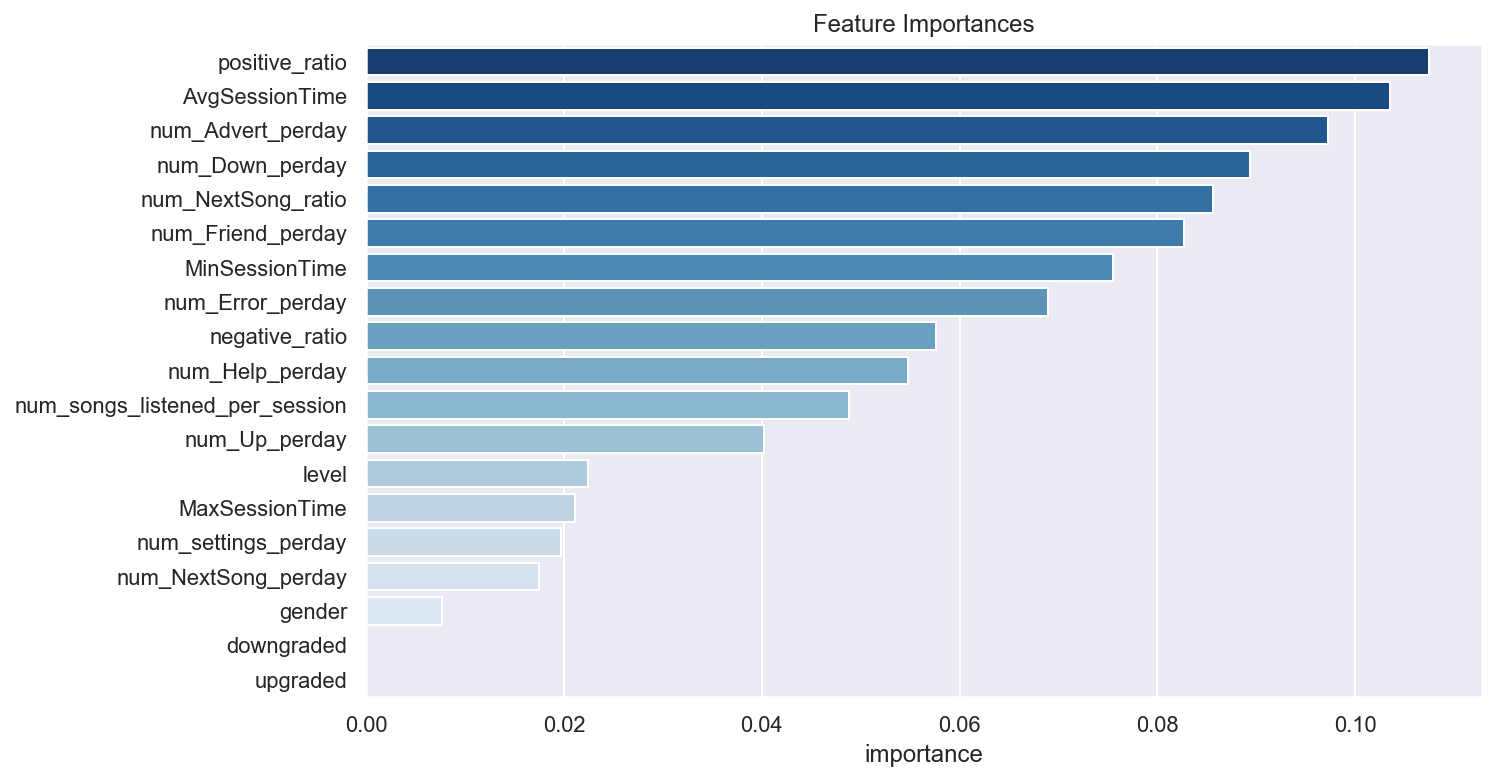

In [159]:
# feature importance from GBT
gbt_best_model = GBTClassifier(maxIter=20, maxDepth=4)
best_pipelines = Pipeline(stages=[gbt_best_model])
gbt = best_pipelines.fit(user_train)
gbt_importance = gbt.stages[-1].featureImportances
gbt_importance_lst = [gbt_importance[i] for i in range(len(gbt_importance))]
names = numeric_lst+category_lst
gbt_importance_df = pd.DataFrame({"feature": names,"importance": gbt_importance_lst, })\
                           .sort_values('importance', ascending = False)
plt.figure(figsize=(10,6))
sns.barplot(y='feature',x='importance',data=gbt_importance_df,palette='Blues_r',zorder=2);
plt.title("Feature Importances")
plt.ylabel("");

From the above feature importance figure, it can be concluded that `gender` and `level` are not so important. 

By comparison, the following is the top 5 important features:
- `positive ratio` (the users' positive interaction on `Sparkigy`)
- `AvgSessionTime` (users' average session time)
- `num_Advert_perday` (number of advertisements users see per day)
- `num_Down_perday` (number of users' thumb-down times)
- `num_NextSong_ratio` (number of songs listened among all the interaction times)

Therefore, the following advice may help `Sparkify` prevent losing customers
- Increase number of users' positive interactions on `Sparkify`
- Increase the average session time of users
- Increase the number of good ads and decrease the number of bad ads
- Find some ways to decrease the thumb-down times
- Improve the quality of songs on `Sparkigy`

# Conclusion

**Reflection**

I have built three binary classifier models to identify churned users and it turned out that the `Gradient-Boosted Tree` model performed best. However, the average F1 score is still low because of the small-size dataset(only 448 unique users).

The most challenging part is the feature engineering part. It requires good intuition and creativity since there are thousands of aspects to extract the features from the data and only a few matter. I was adviced to go to this [website](https://elitedatascience.com/feature-engineering-best-practices) to see how to do feature engineering. At the same time, I was also encountered the `Data Leakage` problem in machine learning. I restarted doing the feature engineering process and solved this problem.


**Potential Improvements**

- build and test features that capture additional insights about user's activity patterns, e.g. average length of song listening sessions, ratios of skipped or partially listened songs, etc.
- utilize song-level features that have been ignored so far, e.g. calculate the user's listening diversity in terms of different songs/artists listened to in the specified observation period, etc.
- optimize data wrangling and feature engineering steps 
- perform the model on full Sparkify dataset, using the EMR cluster